In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## functions

In [2]:
def plot_graph(arr, delimeter=93, ylabel='L2 hitrate', xlabel='kernels (in-order)'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.axvline(x=delimeter, color='r', linestyle='--')
    ax.plot(arr)

def plot_bar(arr, delimeter=93, ylabel='', xlabel='kernels'):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.axvline(x=delimeter, color='r', linestyle='--')
    ax.bar(list(range(len(arr))), height=arr, width=1)

def exclusive_scan(arr):
    scan = np.zeros_like(arr)
    for i in range(len(arr)):
        s = 0
        for j in range(i):
            s+=arr[j]
        scan[i] = s
    return scan

def create_timearray(durations, arr, timestep=0.001, delimeter = 93):
    durations = np.trunc(durations/timestep).astype(np.int32)
    total_time = sum(durations)
    start_times = exclusive_scan(durations)
    output = np.zeros(total_time)
    for i in range(len(durations)):
        output[start_times[i]:start_times[i]+durations[i]] = arr[i]
    return output, start_times[delimeter]

def get_global_averages(arr, delimeter):
    f = arr[:delimeter]
    b = arr[delimeter:]

    f = f[np.logical_not(np.isnan(f))]
    b = b[np.logical_not(np.isnan(b))]

    print("Average for forward is {}".format(f.mean()))
    print("Average for backward is {}".format(b.mean()))

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def ma_analysis(arr, old_delimeter, n=10000):

    f = arr[:old_delimeter]
    b = arr[old_delimeter:]

    f = f[np.logical_not(np.isnan(f))]
    b = b[np.logical_not(np.isnan(b))]

    f_ma = moving_average(f, n)
    b_ma = moving_average(b, n)

    delimeter = len(f_ma)
    out = np.concatenate((f_ma, b_ma))

    return out, delimeter

def create_timearray_separate_streams(df, metric, timestep=0.001, delimeter = 93):
    #communication stream
    df_comm = df.loc[df['Name'].str.contains('nccl', case=False)]
    vals_comm = df_comm[metric].astype(float).to_numpy()
    durations_comm = df_comm['Duration'].astype(float).to_numpy()
    durations_comm = np.trunc(durations_comm/timestep).astype(np.int32)
    idx_comm = df_comm.index.to_numpy()
    ##__

    #computation stream
    df_comp = df.drop(index=idx_comm)
    df_comp = df_comp.reset_index(drop=True)
    vals_comp = df_comp[metric].astype(float).to_numpy()
    durations_comp = df_comp['Duration'].astype(float).to_numpy()
    durations_comp = np.trunc(durations_comp/timestep).astype(np.int32)
    ##__

    total_time = sum(durations_comp) + sum(durations_comm) 

    tvals_comm = np.zeros(total_time)
    tvals_comp = np.zeros(total_time)

    starttimes_comp = exclusive_scan(durations_comp)

    #adjust comm indexes, since we removed them
    for i in range(len(idx_comm)):
        idx_comm[i] = idx_comm[i] - i - 1
    
    starttimes_comm = starttimes_comp[idx_comm]

    for i in range(len(durations_comm)):
        tvals_comm[starttimes_comm[i]:starttimes_comm[i]+durations_comm[i]] = vals_comm[i]

    for i in range(len(durations_comp)):
        tvals_comp[starttimes_comp[i]:starttimes_comp[i]+durations_comp[i]] = vals_comp[i]
    
    new_delimeter = starttimes_comp[delimeter-1]

    # print(np.nanmean(vals_comm))
    # print(np.nanmean(vals_comp))

    return tvals_comp, tvals_comm, new_delimeter

def plot_bar_overlap(comp, comm, delimeter, ylabel, xlabel):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(111)
    plt.tight_layout()
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.axvline(x=delimeter, color='r', linestyle='--')
    ax.bar(list(range(len(comp))), height=comp, width=1, color='b', label='computation')
    ax.bar(list(range(len(comm))), height=comm, width=1, color='r', label='communication', alpha=0.5)
    plt.legend()

def separate_streams(df, metric, delimeter=93):
    #communication stream
    df_comm = df.loc[df['Name'].str.contains('nccl', case=False)]
    vals_comm = df_comm[metric].astype(float).to_numpy()
    idx_comm = df_comm.index.to_numpy()
    ##__

    #computation stream
    df_comp = df.drop(index=idx_comm)
    df_comp = df_comp.reset_index(drop=True)
    vals_comp = df_comp[metric].astype(float).to_numpy()

    total_len = len(vals_comp) + len(vals_comm)

    out_comp = np.zeros(total_len)
    out_comm = np.zeros(total_len)

    

    for i in range(len(idx_comm)):
        idx_comm[i] = idx_comm[i] - i

    for i in range(total_len):
        if i<len(vals_comp):
            out_comp[i] = vals_comp[i]
        
        for j in range(len(idx_comm)):
            if idx_comm[j] == i:
                out_comm[i]=vals_comm[j]

    return out_comp, out_comm, delimeter

## profiling

In [3]:
#model = 'resnet50'
#model = 'resnet152'
model = 'vgg16'

In [4]:
l2r_df = pd.read_csv('./src/'+model+'/nvprof_l2r_multigpu.csv')
l2r_df = l2r_df.drop(0)
l2r_df = l2r_df.reset_index(drop=True)

l2w_df = pd.read_csv('./src/'+model+'/nvprof_l2w_multigpu.csv')
l2w_df = l2w_df.drop(0)
l2w_df = l2w_df.reset_index(drop=True)

# f [0-93)
# b [127-352)
# drop = [93-127)


In [5]:
l2r_df = l2r_df.drop(index = list(range(93,127))+list(range(352,len(l2r_df))))
l2w_df = l2w_df.drop(index = list(range(93,127))+list(range(352,len(l2w_df))))

In [6]:
l2r_df = l2r_df.reset_index(drop=True)
l2w_df = l2w_df.reset_index(drop=True)

# f [0-92]
# b [93 - :]

In [8]:
l2r_comp, l2r_comm, delimeter1 = separate_streams(l2r_df, 'l2_read_transactions')

In [9]:
l2w_comp, l2w_comm, delimeter2 = separate_streams(l2w_df, 'l2_write_transactions')

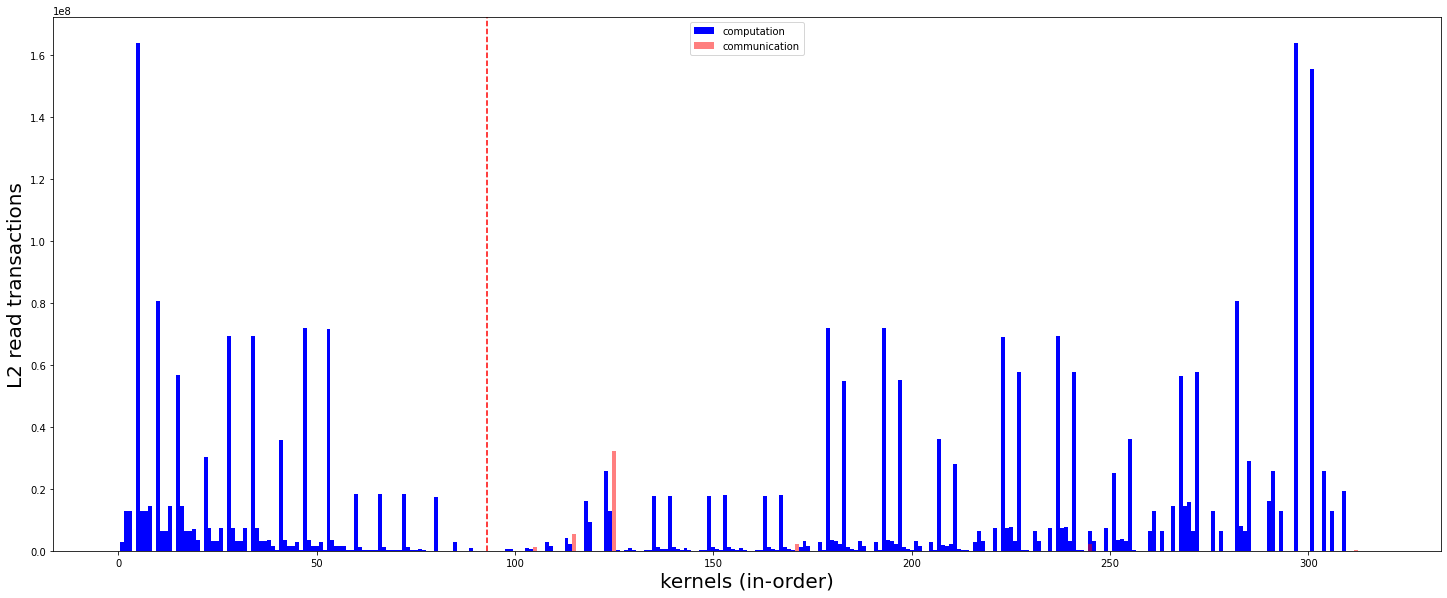

In [10]:
plot_bar_overlap(l2r_comp, l2r_comm, delimeter1, 'L2 read transactions', 'kernels (in-order)')

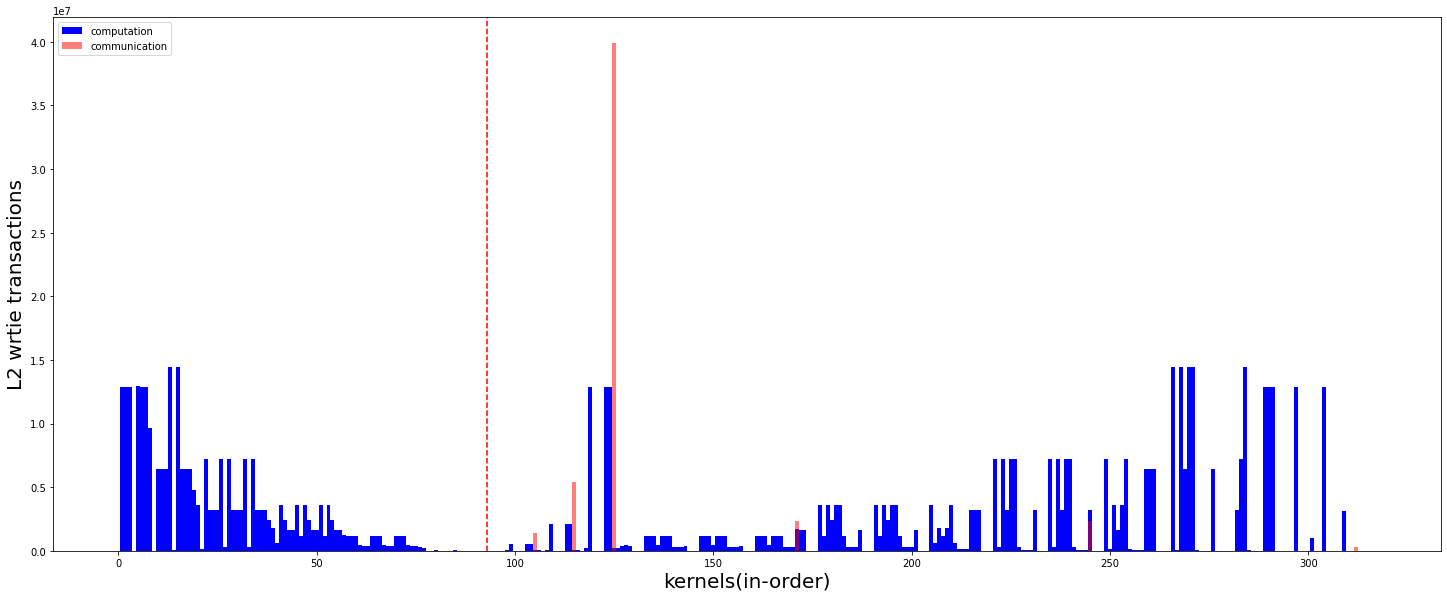

In [11]:
plot_bar_overlap(l2w_comp, l2w_comm, delimeter2, 'L2 wrtie transactions', 'kernels(in-order)')